<a href="https://colab.research.google.com/github/xvrfcsxul/mlproject/blob/main/catboostreg1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных с диска

In [ ]:
! gdown 1JK6UkB2NHwtRfZq0UA7peNlP9nkCeCnH
! unzip -o /content/leopard-challenge-regression.zip -d /content/leoaprd-challenge-regression

Downloading...
From: https://drive.google.com/uc?id=1JK6UkB2NHwtRfZq0UA7peNlP9nkCeCnH
To: /content/leopard-challenge-regression.zip
100% 1.00M/1.00M [00:00<00:00, 117MB/s]
Archive:  /content/leopard-challenge-regression.zip
  inflating: /content/leoaprd-challenge-regression/sample_submission.csv  
  inflating: /content/leoaprd-challenge-regression/test.csv  
  inflating: /content/leoaprd-challenge-regression/train.csv  


# Установка catboost, phik и shap

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.4 MB/s eta 0:00:00


In [ ]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 13.6 MB/s eta 0:00:00


# Задача
Это данные о ценах на недвижимость в Мельбурне. Каждая строчка – это объект недвижимости, по которому известны некоторые параметры и его цена. Задача заключается в том, чтобы по этим параметрам определить цену объекта.

### Метрика
Предсказание модели будет оцениваться по MAPE (mean absolute Percentage error) – средняя абсолютная ошибка в процентах.

### Описание данных

* Suburb – Район
* Address – адрес
* Rooms – количество комнат
* Type – тип объекта
  -  br - bedroom(s);
  -  h - house,cottage,villa, semi,terrace;
  -  u - unit, duplex;
  -  t - townhouse;
  -  dev site - development site;
  -  o res - other residential.
* Price – цена объекта
* Method – метод продажи объекта:
  -  S - property sold;
  -  SP - property sold prior;
  -  PI - property passed in;
  -  PN - sold prior not disclosed;
  -  SN - sold not disclosed;
  -  NB - no bid;
  -  VB - vendor bid;
  -  W - withdrawn prior to auction;
  -  SA - sold after auction;
  -  SS - sold after auction price not disclosed.
  -  N/A - price or highest bid not available.
* SellerG – имя риэлтора
* Date – дата продажи объекта
* Distance – расстояние до центрального района в километрах
* Postcode – почтовый индекс
* Bedrooms2 – количество спален
* Bathroom – количество ванных комнат
* Car – количество парковочных мест
* Landsize – площадь прилегающей территории
* BuildingArea – площадь самого объекта
* YearBuilt – год постройки
* CouncilArea – округ
* Lattitude – широта
* Longtitude – долгота
* Regionname – еще одно административное деление на подобие округа
* Propertycount – не совсем ясно что, возможно количество объектов в округе
* id – id объекта



In [ ]:
import pandas as pd
import numpy as np
import phik
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from catboost import Pool

In [ ]:
train = pd.read_csv('/content/leoaprd-challenge-regression/train.csv')
test = pd.read_csv('/content/leoaprd-challenge-regression/test.csv')
train.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809


# EDA. Анализ train

### Размерность данных

In [ ]:
print('Число объектов: ', train.shape[0], '\n',
      'Число признаков: ', train.shape[1], sep='')

Число объектов: 18373
Число признаков: 22


### Процент пропусков в данных

In [ ]:
train.isna().mean() * 100

Suburb            0.000000
Address           0.000000
Rooms             0.000000
Type              0.000000
Price             0.000000
Method            0.000000
SellerG           0.000000
Date              0.000000
Distance          0.000000
Postcode          0.000000
Bedroom2         18.875524
Bathroom         18.886409
Car              19.457900
Landsize         26.092636
BuildingArea     57.818538
YearBuilt        51.319872
CouncilArea       0.005443
Lattitude        18.135307
Longtitude       18.135307
Regionname        0.005443
Propertycount     0.005443
id                0.000000
dtype: float64

### Описательные статистики

In [ ]:
train.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id
count,18373.000000,1.837300e+04,18373.000000,18373.000000,14905.000000,14903.000000,14798.000000,13579.000000,7750.000000,8944.000000,15041.000000,15041.000000,18372.000000,18373.000000
mean,2.936592,1.053235e+06,10.403962,3107.258314,2.914928,1.538683,1.617313,558.937403,151.133167,1965.925089,-37.809872,144.996486,7518.621489,17490.731889
std,0.955952,6.217973e+05,6.018424,95.285542,0.962743,0.688374,0.957072,3991.516323,519.517626,36.958956,0.081272,0.106536,4487.143499,10075.864589
min,1.000000,2.270000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000,2.000000
25%,2.000000,6.350000e+05,6.300000,3046.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1950.000000,-37.858180,144.931400,4294.000000,8749.000000
50%,3.000000,8.800000e+05,9.700000,3085.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.803600,145.001100,6567.000000,17497.000000
75%,3.000000,1.301000e+06,13.300000,3149.000000,3.000000,2.000000,2.000000,651.000000,173.862500,2000.000000,-37.756100,145.060190,10331.000000,26286.000000
max,12.000000,5.580000e+06,48.100000,3978.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000,34856.000000


# EDA. Анализ test

### Размерность данных

In [ ]:
print('Число объектов: ', test.shape[0], '\n',
      'Число признаков: ', test.shape[1], sep='')

Число объектов: 8818
Число признаков: 21


### Процент пропусков в данных

In [ ]:
test.isna().mean() * 100

Suburb            0.000000
Address           0.000000
Rooms             0.000000
Type              0.000000
Method            0.000000
SellerG           0.000000
Date              0.000000
Distance          0.011340
Postcode          0.011340
Bedroom2         33.567702
Bathroom         33.613064
Car              36.697664
Landsize         50.498979
BuildingArea     67.316852
YearBuilt        64.708551
CouncilArea       0.022681
Lattitude        33.000680
Longtitude       33.000680
Regionname        0.022681
Propertycount     0.022681
id                0.000000
dtype: float64

### Описательные статистики

In [ ]:
test.describe()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id
count,8818.000000,8817.000000,8817.000000,5858.000000,5854.000000,5582.000000,4365.000000,2882.000000,3112.000000,5908.000000,5908.000000,8816.000000,8818.000000
mean,3.109549,13.134127,3127.554384,3.381871,1.724120,1.976173,700.659336,171.632200,1968.751928,-37.799458,144.997531,7668.367627,17295.584826
std,0.934280,7.852206,137.628532,0.837767,0.708429,1.040295,2928.526260,140.695197,35.968997,0.113661,0.150998,4498.895777,10008.851866
min,1.000000,0.000000,3000.000000,1.000000,1.000000,0.000000,29.000000,0.000000,1820.000000,-38.190430,144.423790,83.000000,1.000000
25%,3.000000,7.200000,3047.000000,3.000000,1.000000,1.000000,410.000000,118.000000,1950.000000,-37.871178,144.907508,4380.000000,8620.750000
50%,3.000000,12.000000,3095.000000,3.000000,2.000000,2.000000,587.000000,151.000000,1975.000000,-37.791325,145.012550,6763.000000,17271.500000
75%,4.000000,17.300000,3165.000000,4.000000,2.000000,2.000000,696.000000,200.000000,2000.000000,-37.723930,145.092100,10529.000000,25942.500000
max,16.000000,48.100000,3978.000000,16.000000,9.000000,18.000000,146699.000000,6178.000000,2019.000000,-37.397800,145.523700,21650.000000,34846.000000


## Посмотрим на корреляцию признаков с целевым при помощи phi_K

In [ ]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'id']


/usr/local/lib/python3.9/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Address is large: 18112. Are you sure this is not an interval variable? Analysis for pairs of variables including Address can be slow.
  warnings.warn(


In [ ]:
phik_overview['Price'].sort_values(ascending=False)

Price            1.000000
Address          0.914628
Suburb           0.610118
Rooms            0.550306
CouncilArea      0.507873
Type             0.503994
SellerG          0.479557
YearBuilt        0.440424
Bathroom         0.395110
Car              0.375106
Lattitude        0.367261
Longtitude       0.352421
Bedroom2         0.350515
Regionname       0.315438
Postcode         0.284862
Propertycount    0.255545
Distance         0.232190
Method           0.173762
Date             0.138047
Landsize         0.053294
id               0.026305
BuildingArea     0.000000
Name: Price, dtype: float64

<AxesSubplot:>

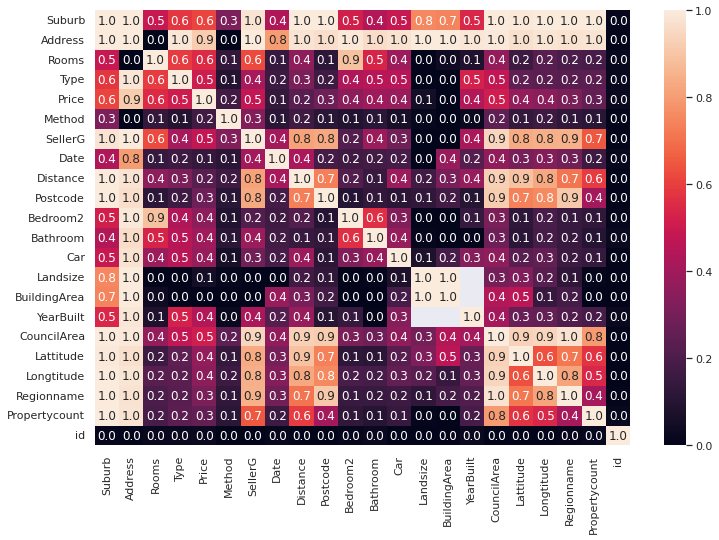

In [ ]:
sns.set(rc={"figure.figsize":(12,8)})
sns.heatmap(phik_overview, annot=True, fmt=".1f")

# Анализ признаков
### Рассмотрение начнем с признака с наибольшей величиной phi_k - Address.
##### Адресс дома кажется не самой лучшей фичей с точки зрения обобщения, в силу потенциально большого числа вариантов, что в свою очередь может плохо отразиться на предсказании. Поскольку в train может не быть информации по большому проценту домов в Мельбурне, но которые могут встретится в test

In [ ]:
len(set(test.Address).intersection(train.Address))

179

Что и следовало ожидать. Лишь 179 адресов домов пересекаются в train и test.Поэтому создадим более общую фичу - улица

In [ ]:
train['Street'] = train['Address'].apply(lambda x: ' '.join(x.split()[1:]))
test['Street'] = test['Address'].apply(lambda x: ' '.join(x.split()[1:]))

In [ ]:
len(set(test.Street).intersection(train.Street))

2722

Число пересечений значительно выросло

### Далее поработаем с датой продажи объекта.
##### В качестве преобразования даты попробуем для модели следующие варианты:  

- разделить дату на день, месяц, год;
- перевести дату в секунды;
- создать новую фичу - разница между годом продажи дома и годом постройки

##### Перед тем как создать фичу с разницей лет между продажей объекта и годом постройки, необходимо заполнить пропуски в признаке YearBuilt

In [ ]:
train['second'] = pd.to_datetime(train['Date']).astype(int);
train['year'] = pd.to_datetime(train.Date).dt.year;
train['month'] = pd.to_datetime(train.Date).dt.month;
train['day'] = pd.to_datetime(train.Date).dt.day;

test['second'] = pd.to_datetime(test['Date']).astype(int);
test['year'] = pd.to_datetime(test.Date).dt.year;
test['month'] = pd.to_datetime(test.Date).dt.month;
test['day'] = pd.to_datetime(test.Date).dt.day;

### Для заполнения признаков будем последовательно применять catboost, обучаясь на train, прогнозируя пропуски сначала в train, а затем в test. В начале заполним категориальные признаки

In [ ]:
train.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bedroom2          3468
Bathroom          3470
Car               3575
Landsize          4794
BuildingArea     10623
YearBuilt         9429
CouncilArea          1
Lattitude         3332
Longtitude        3332
Regionname           1
Propertycount        1
id                   0
Street               0
second               0
year                 0
month                0
day                  0
dtype: int64

In [ ]:
test.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            1
Postcode            1
Bedroom2         2960
Bathroom         2964
Car              3236
Landsize         4453
BuildingArea     5936
YearBuilt        5706
CouncilArea         2
Lattitude        2910
Longtitude       2910
Regionname          2
Propertycount       2
id                  0
Street              0
second              0
year                0
month               0
day                 0
dtype: int64

### Здесь нам наиболее важно заполнить Regionname и CouncilArea. Поскольку здесь и в train, и в test по одному пропуску заполним их вручную

In [ ]:
train.loc[14406, 'Regionname'] = 'Western Metropolitan'
train.loc[14406, 'CouncilArea'] = 'Maribyrnong City Council'
train.loc[14406, 'Propertycount'] = 7570.0

test.loc[2634, 'Regionname'] = 'Southern Metropolitan'
test.loc[2634, 'CouncilArea'] = 'Boroondara City Council'

test.loc[4628, 'Regionname'] = 'no info'
test.loc[4628, 'CouncilArea'] = 'no info'

In [ ]:
def fill_nan_catboost(train, test, X, y, cat_features):
    train_train_not_na = train[~train[y].isna()].copy()
    train_test_not_na = train[train[y].isna()].copy()
    test_train_not_na = test[~test[y].isna()].copy()
    test_test_not_na = test[test[y].isna()].copy()
    train_train_not_na, val = train_test_split(train_train_not_na, test_size=0.3, random_state=42)
    train_fill_na = Pool(
                            data=train_train_not_na[X],
                            label=train_train_not_na[y],
                            cat_features=cat_features
                        )
    val_fill_na = Pool(
                            data=val[X],
                            label=val[y],
                            cat_features=cat_features
                        )
    params = {
            'loss_function': 'RMSE',
            'eval_metric': 'MAPE',
            'verbose': 100,
            'random_seed': 42,
        }
    model_fill = CatBoostRegressor(**params)
    model_fill.fit(train_fill_na, eval_set=val_fill_na)
    best_iter = model_fill.best_iteration_ + 1
    learning_rate = model_fill.learning_rate_
    full_train = pd.concat([train_train_not_na, val])
    train_fill_na = Pool(
                            data=full_train[X],
                            label=full_train[y],
                            cat_features=cat_features
                        )
    params = {
            'loss_function': 'RMSE',
            'eval_metric': 'MAPE',
            'verbose': 100,
            'random_seed': 42,
            'iterations': best_iter,
            'learning_rate':learning_rate
    }
    final_model_fill = CatBoostRegressor(**params)
    final_model_fill.fit(train_fill_na)
    train_test_not_na[y] = final_model_fill.predict(train_test_not_na[X])
    test_test_not_na[y] = final_model_fill.predict(test_test_not_na[X])
    train = pd.concat([full_train, train_test_not_na])
    test = pd.concat([test_train_not_na, test_test_not_na])
    return train, test

In [ ]:
y = 'Lattitude'
X = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG',
    'Distance', 'Postcode', 'CouncilArea', 'Regionname',
    'Propertycount', 'second']
cat_features = ['Suburb', 'Street', 'Type', 'Method',
                'SellerG', 'CouncilArea', 'Regionname']
train, test = fill_nan_catboost(train, test, X, y, cat_features)

Learning rate set to 0.073689
0:	learn: 0.0015589	test: 0.0015459	best: 0.0015459 (0)	total: 91.6ms	remaining: 1m 31s
100:	learn: 0.0002156	test: 0.0002090	best: 0.0002090 (100)	total: 2.22s	remaining: 19.7s
200:	learn: 0.0001819	test: 0.0001782	best: 0.0001782 (200)	total: 4.28s	remaining: 17s
300:	learn: 0.0001647	test: 0.0001637	best: 0.0001637 (300)	total: 6.63s	remaining: 15.4s
400:	learn: 0.0001517	test: 0.0001532	best: 0.0001532 (400)	total: 9.29s	remaining: 13.9s
500:	learn: 0.0001449	test: 0.0001482	best: 0.0001482 (500)	total: 13.2s	remaining: 13.1s
600:	learn: 0.0001394	test: 0.0001443	best: 0.0001443 (600)	total: 15.3s	remaining: 10.2s
700:	learn: 0.0001343	test: 0.0001410	best: 0.0001410 (700)	total: 17.4s	remaining: 7.42s
800:	learn: 0.0001301	test: 0.0001387	best: 0.0001387 (799)	total: 19.6s	remaining: 4.88s
900:	learn: 0.0001266	test: 0.0001371	best: 0.0001371 (900)	total: 21.8s	remaining: 2.4s
999:	learn: 0.0001241	test: 0.0001359	best: 0.0001359 (998)	total: 25.7s	re

In [ ]:
y = 'Longtitude'
X = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG',
    'Distance', 'Postcode', 'CouncilArea', 'Regionname', 'Lattitude',
    'Propertycount', 'second']
cat_features = ['Suburb', 'Street', 'Type', 'Method',
                'SellerG', 'CouncilArea', 'Regionname']
train, test = fill_nan_catboost(train, test, X, y, cat_features)

Learning rate set to 0.073689
0:	learn: 0.0005104	test: 0.0005105	best: 0.0005105 (0)	total: 26.8ms	remaining: 26.8s
100:	learn: 0.0000762	test: 0.0000772	best: 0.0000772 (100)	total: 2.07s	remaining: 18.4s
200:	learn: 0.0000633	test: 0.0000650	best: 0.0000650 (200)	total: 4.22s	remaining: 16.8s
300:	learn: 0.0000565	test: 0.0000584	best: 0.0000584 (300)	total: 6.34s	remaining: 14.7s
400:	learn: 0.0000522	test: 0.0000542	best: 0.0000542 (400)	total: 8.46s	remaining: 12.6s
500:	learn: 0.0000494	test: 0.0000518	best: 0.0000518 (500)	total: 12.7s	remaining: 12.7s
600:	learn: 0.0000469	test: 0.0000498	best: 0.0000498 (600)	total: 15s	remaining: 9.94s
700:	learn: 0.0000451	test: 0.0000487	best: 0.0000487 (700)	total: 17.1s	remaining: 7.31s
800:	learn: 0.0000436	test: 0.0000478	best: 0.0000478 (800)	total: 19.4s	remaining: 4.81s
900:	learn: 0.0000423	test: 0.0000472	best: 0.0000472 (900)	total: 21.6s	remaining: 2.37s
999:	learn: 0.0000411	test: 0.0000467	best: 0.0000467 (998)	total: 25.1s	re

In [ ]:
y = 'YearBuilt'
X = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG',
    'Distance', 'Postcode', 'CouncilArea', 'Regionname', 'Lattitude',
     'Longtitude', 'Propertycount', 'second']
cat_features = ['Suburb', 'Street', 'Type', 'Method',
                'SellerG', 'CouncilArea', 'Regionname']
train, test = fill_nan_catboost(train, test, X, y, cat_features)

Learning rate set to 0.067914
0:	learn: 0.0146530	test: 0.0147752	best: 0.0147752 (0)	total: 19.9ms	remaining: 19.9s
100:	learn: 0.0102919	test: 0.0104755	best: 0.0104755 (100)	total: 1.51s	remaining: 13.5s
200:	learn: 0.0098906	test: 0.0103290	best: 0.0103287 (199)	total: 2.97s	remaining: 11.8s
300:	learn: 0.0095397	test: 0.0102564	best: 0.0102524 (296)	total: 4.44s	remaining: 10.3s
400:	learn: 0.0092728	test: 0.0102244	best: 0.0102243 (399)	total: 5.94s	remaining: 8.87s
500:	learn: 0.0090105	test: 0.0102112	best: 0.0102095 (492)	total: 7.48s	remaining: 7.45s
600:	learn: 0.0087671	test: 0.0102160	best: 0.0102027 (570)	total: 9.32s	remaining: 6.18s
700:	learn: 0.0085470	test: 0.0102164	best: 0.0102027 (570)	total: 12.7s	remaining: 5.43s
800:	learn: 0.0083683	test: 0.0102308	best: 0.0102027 (570)	total: 14.3s	remaining: 3.55s
900:	learn: 0.0081715	test: 0.0102413	best: 0.0102027 (570)	total: 15.8s	remaining: 1.74s
999:	learn: 0.0079625	test: 0.0102287	best: 0.0102027 (570)	total: 17.3s	

In [ ]:
y = 'Bedroom2'
X = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG', 'Distance',
     'Postcode', 'CouncilArea', 'Regionname', 'Lattitude', 'Longtitude',
     'Propertycount', 'second', 'YearBuilt']
cat_features = ['Suburb', 'Street', 'Type', 'Method',
                'SellerG', 'CouncilArea', 'Regionname']
train, test = fill_nan_catboost(train, test, X, y, cat_features)

Learning rate set to 0.073584
0:	learn: 0.2863750	test: 0.2941369	best: 0.2941369 (0)	total: 25.6ms	remaining: 25.6s
100:	learn: 0.0349107	test: 0.0364151	best: 0.0364151 (100)	total: 2.29s	remaining: 20.4s
200:	learn: 0.0324873	test: 0.0349443	best: 0.0349200 (196)	total: 4.38s	remaining: 17.4s
300:	learn: 0.0317782	test: 0.0349937	best: 0.0348970 (212)	total: 6.46s	remaining: 15s
400:	learn: 0.0310682	test: 0.0352256	best: 0.0348970 (212)	total: 10.3s	remaining: 15.5s
500:	learn: 0.0305881	test: 0.0356162	best: 0.0348970 (212)	total: 13.1s	remaining: 13s
600:	learn: 0.0301660	test: 0.0359862	best: 0.0348970 (212)	total: 15.3s	remaining: 10.2s
700:	learn: 0.0296253	test: 0.0361660	best: 0.0348970 (212)	total: 17.6s	remaining: 7.51s
800:	learn: 0.0293466	test: 0.0365846	best: 0.0348970 (212)	total: 19.9s	remaining: 4.95s
900:	learn: 0.0290463	test: 0.0368320	best: 0.0348970 (212)	total: 23.6s	remaining: 2.59s
999:	learn: 0.0286688	test: 0.0370547	best: 0.0348970 (212)	total: 26.8s	rema

### Таким образом, были заполнены наиболее податливые признаки с приемлемым MAPE на валидации. Остальные фичи выдают MAPE > 100

##### Теперь округлим до целого год постройки и количество спален, поскольку после catboost данные фичи стали непрерывными

In [ ]:
train['Bedroom2'] = train['Bedroom2'].round()
train['YearBuilt'] = train['YearBuilt'].round()

test['Bedroom2'] = test['Bedroom2'].round()
test['YearBuilt'] = test['YearBuilt'].round()

##### Наконец создадим признак с разностью года постройки и даты продажи объекта

In [ ]:
train['years_purch_to_sale'] = pd.to_datetime(train.Date).dt.year - train['YearBuilt'].apply(int)
test['years_purch_to_sale'] = pd.to_datetime(test.Date).dt.year - test['YearBuilt'].apply(int)

### Распределение Price

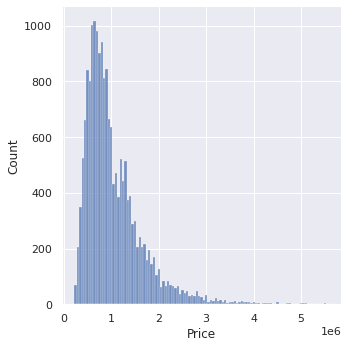

In [ ]:
sns.set(rc={"figure.figsize":(12,8)})
sns.displot(train['Price'])

### Как и стоило ожидать распределение цен имеет экспоненциальный характер - этот факт является важным для выбора функции ошибок, а именно аргументом к выбору робастной функции ошибки. К тому же, в соревновании критерием оценки является MAPE, что подталкивает нас в качестве функции ошибки выбрать MAE

### Посмотрим на ряд зависимостей числовых переменных с ценой на объект. Начнем с комнат:

In [ ]:
rooms_price = train.groupby('Rooms', as_index=False) \
                    .aggregate({'Price':'mean', 'id':'count'}) \
                    .rename(columns={'Price':'mean_price', 'id':'cnt'})

rooms_price

,Rooms,mean_price,cnt
0,1,4.420956e+05,886
1,2,7.556338e+05,4995
2,3,1.050731e+06,7958
3,4,1.426808e+06,3646
4,5,1.829385e+06,768
5,6,1.770828e+06,90
6,7,1.759385e+06,13
7,8,1.824727e+06,11
8,9,1.380000e+06,1
9,10,1.943750e+06,4


<AxesSubplot:xlabel='Rooms', ylabel='mean_price'>

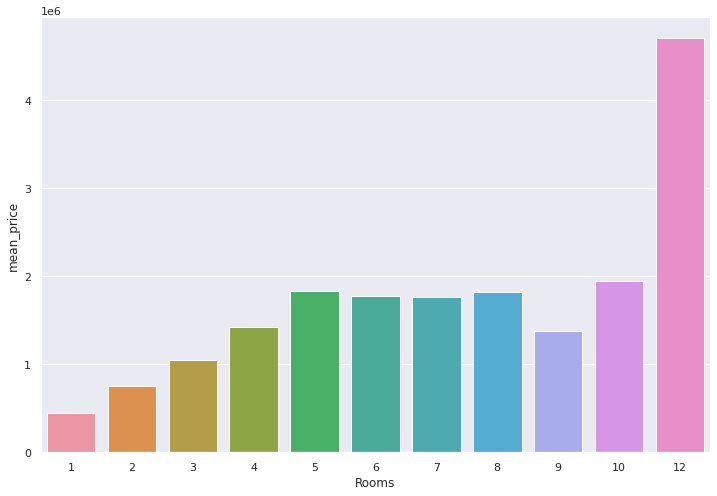

In [ ]:
sns.barplot(data=rooms_price, x='Rooms', y='mean_price')

### В целом, переменная Rooms хорошо описывает тренд, если учесть, что объектов, имеющих большое количество комнат мало и цена на них явно "не сходится" к истинному значению

### Зависимость цены от расстояния до центрального района:

<AxesSubplot:xlabel='Distance', ylabel='Price'>

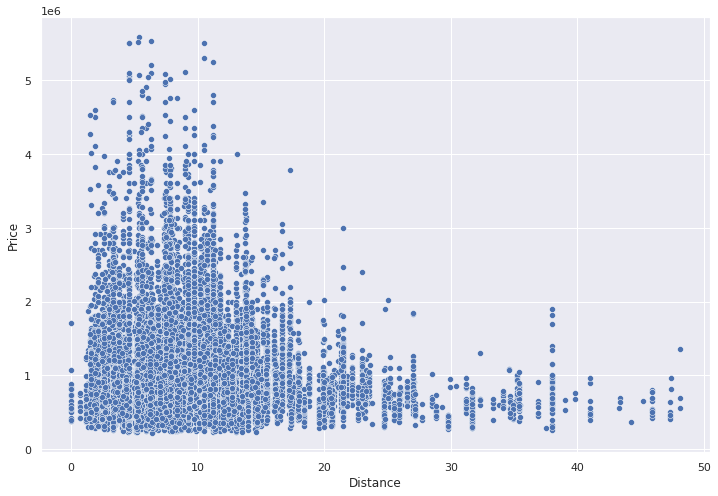

In [ ]:
sns.scatterplot(x=train['Distance'], y=train['Price'])

### Здесь также все логично, цена уменьшается по мере отдаления от центра города

### Зависимость цены от типа недвижимости:

In [ ]:
type_price = train.groupby('Type', as_index=False) \
                    .aggregate({'Price':'mean', 'id':'count'}) \
                    .rename(columns={'Price':'mean_price', 'id':'cnt'})
type_price

,Type,mean_price,cnt
0,h,1.227437e+06,12091
1,t,9.241168e+05,2007
2,u,6.211548e+05,4275


<AxesSubplot:xlabel='Type', ylabel='mean_price'>

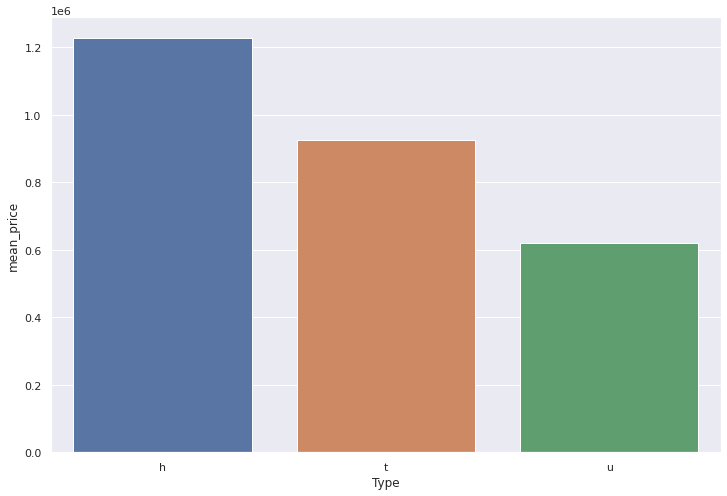

In [ ]:
sns.barplot(data=type_price, x='Type', y='mean_price')

### Зависимость цены от года постройки:

In [ ]:
train['YearBuilt'].min()

1196.0

##### Находим минимальный год равный 1196, что однозначно является выбросом, поскольку Мельбурн был образован в XIX веке. Посмотрим детальнее на этот дом

In [ ]:
train[train['YearBuilt'] == 1196]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Longtitude,Regionname,Propertycount,id,Street,second,year,month,day,years_purch_to_sale
12721,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,24/06/2017,14.2,3149.0,...,145.12121,Eastern Metropolitan,13366.0,11846,Armstrong St,1498262400000000000,2017,6,24,821


##### Заменим данный год пойстройки на наиболее правдоподобный

In [ ]:
train.loc[12721, 'YearBuilt'] = 1996

In [ ]:
train['YearBuilt_groups'] = pd.cut(train['YearBuilt'], bins=[1850, 1900, 1920, 1940, 1960, 1980, 2000, 2010, 2020])

year_price = train.groupby('YearBuilt_groups', as_index=False) \
                    .aggregate({'Price':'mean', 'id':'count'}) \
                    .rename(columns={'Price':'mean_price', 'id':'cnt'}) \
                    .sort_values(['mean_price', 'cnt'], ascending=[False, False])
year_price

,YearBuilt_groups,mean_price,cnt
1,"(1900, 1920]",1.546733e+06,1030
0,"(1850, 1900]",1.513886e+06,755
2,"(1920, 1940]",1.448476e+06,1714
3,"(1940, 1960]",1.205254e+06,3577
7,"(2010, 2020]",9.300845e+05,824
6,"(2000, 2010]",8.836802e+05,1804
4,"(1960, 1980]",8.698624e+05,5334
5,"(1980, 2000]",8.453806e+05,3330


<AxesSubplot:xlabel='YearBuilt', ylabel='Price'>

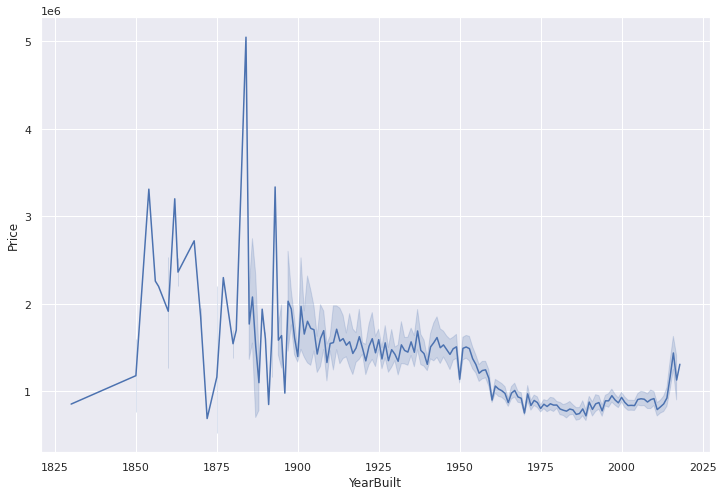

In [ ]:
sns.lineplot(x=train['YearBuilt'], y=train['Price'])

##### Отсюда можно увидеть, что чем раньше построен объект, тем дороже он стоит. Скорее всего, это объясняется тем, что данные объекты расположены в центре города и являются полноценными домами (type - h)

### Зависимость цены от региона:

In [ ]:
region_price = train.groupby('Regionname', as_index=False) \
                    .aggregate({'Price':'median', 'id':'count'}) \
                    .rename(columns={'Price':'mean_price', 'id':'cnt'})
region_price

,Regionname,mean_price,cnt
0,Eastern Metropolitan,1000500.0,1999
1,Eastern Victoria,689000.0,79
2,Northern Metropolitan,765000.0,5305
3,Northern Victoria,547000.0,63
4,South-Eastern Metropolitan,815000.0,683
5,Southern Metropolitan,1225000.0,6326
6,Western Metropolitan,765000.0,3876
7,Western Victoria,388750.0,42


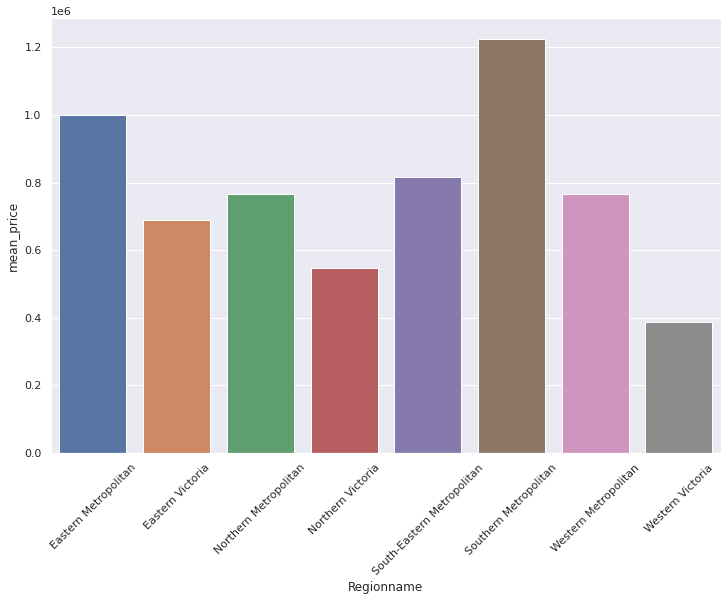

In [ ]:
sns.barplot(data=region_price, x='Regionname', y='mean_price')
plt.xticks(rotation=45);

### Зависимость цены от площади объекта

In [ ]:
train['BuildingArea_groups'] = pd.cut(train['BuildingArea'], bins=[0, 30, 50, 70, 90, 110, 130, 160, 200, 250, 300, 1000])
area_price = train.groupby('BuildingArea_groups', as_index=False) \
                    .aggregate({'Price':'median', 'id':'count'}) \
                    .rename(columns={'Price':'mean_price', 'id':'cnt'}) \
                    .sort_values('mean_price', ascending=False)
area_price

,BuildingArea_groups,mean_price,cnt
10,"(300, 1000]",2020000.0,346
9,"(250, 300]",1740000.0,330
8,"(200, 250]",1450000.0,600
7,"(160, 200]",1200000.0,1017
6,"(130, 160]",960250.0,1298
5,"(110, 130]",880000.0,1157
0,"(0, 30]",852000.0,106
4,"(90, 110]",790000.0,1157
3,"(70, 90]",630100.0,907
2,"(50, 70]",480000.0,563


### Нашли ряд объектов типа дом, таун-хаус, юнит с площадью 0, изменим для них площадь

In [ ]:
house_less_30 = train[(train['BuildingArea'] <= 30) & (train['Type'] == 'h')]['YearBuilt'].index
train.loc[house_less_30, 'BuildingArea'] = train.loc[house_less_30, 'Rooms'] * 49

In [ ]:
townhouse_less_30 = train[(train['BuildingArea'] <= 30) & (train['Type'] == 't')]['YearBuilt'].index
train.loc[townhouse_less_30, 'BuildingArea'] = train.loc[townhouse_less_30, 'Rooms'] * 50

In [ ]:
unit_less_30 = train[(train['BuildingArea'] <= 30) & (train['Type'] == 'u')]['YearBuilt'].index
train.loc[unit_less_30, 'BuildingArea'] = 80

In [ ]:
# train.query("Type == 'u'").groupby(['Rooms', 'YearBuilt_groups']).aggregate({'BuildingArea':'median'}).dropna()

In [ ]:
# train[(train['BuildingArea'] <= 30) & (train['Type'] == 'u')]['Rooms']

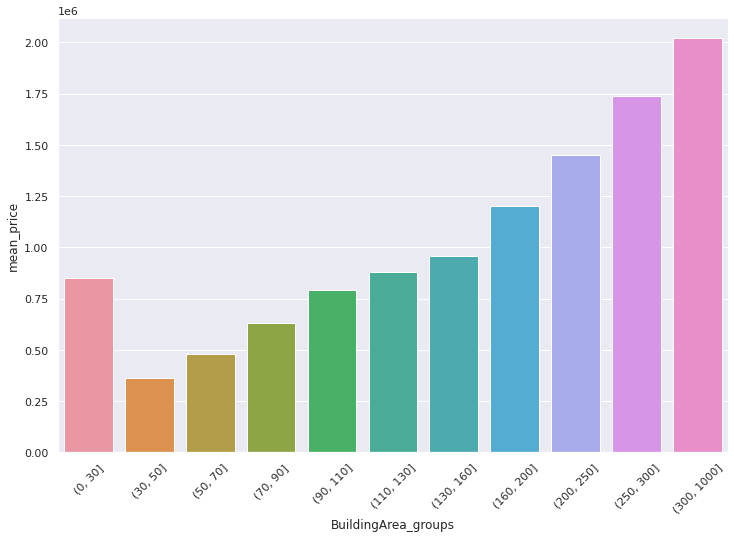

In [ ]:
sns.barplot(data=area_price, x='BuildingArea_groups', y='mean_price')
plt.xticks(rotation=45);

### На данном графике явно видна закономерность: чем больше площадь объекта, тем выше цена.

# Построение модели

### По результатам экспериментов данный набор признаков дает наилучшие результаты

In [ ]:
X = ['Suburb', 'Street', 'Rooms', 'Type', 'Method', 'SellerG',
     'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
     'Longtitude', 'Regionname', 'Propertycount', 'second']
y = ['Price']
cat_features = ['Suburb', 'Street', 'Type', 'Method',
                'SellerG', 'CouncilArea', 'Regionname']

### Задаем сетку для перебора параметров модели

In [ ]:
grid = {'learning_rate':[0.03, 0.035, 0.04, 0.05, 0.06],
        'depth': [8, 9],
        'l2_leaf_reg': [2.5, 3, 3.5, 4]}

In [ ]:
train_data = Pool(
                    data=train[X],
                    label=train[y],
                    cat_features=cat_features
                 )

In [ ]:
params = {'loss_function': 'MAE',
            'random_seed': 42,
            'verbose': 100,
            'eval_metric': 'MAPE',
            'early_stopping_rounds': 70}

model = CatBoostRegressor(**params)
result = model.randomized_search(grid,
                                 train_data,
                                 search_by_train_test_split=False,
                                 n_iter=30,
                                 cv=4)

model.save_model('/content/drive/MyDrive/models/catboost_model_j.json')

### Создаем модель по лучшим параметрам, полученным после перебора

In [ ]:
params = {'loss_function': 'MAE',
            'random_seed': 42,
            'verbose': 100,
            'eval_metric': 'MAPE',
            'depth': 8,
            'learning_rate': 0.03125,
            'l2_leaf_reg': 3.5}

model = CatBoostRegressor(**params)
model.fit(train_data)

0:	learn: 0.4159115	total: 66.5ms	remaining: 1m 6s
100:	learn: 0.1690963	total: 5.79s	remaining: 51.6s
200:	learn: 0.1501038	total: 13.6s	remaining: 54s
300:	learn: 0.1409541	total: 19.2s	remaining: 44.6s
400:	learn: 0.1338126	total: 26.1s	remaining: 38.9s
500:	learn: 0.1279230	total: 32.5s	remaining: 32.4s
600:	learn: 0.1233489	total: 46.9s	remaining: 31.1s
700:	learn: 0.1194347	total: 53.3s	remaining: 22.7s
800:	learn: 0.1161371	total: 1m	remaining: 15.1s
900:	learn: 0.1135193	total: 1m 6s	remaining: 7.34s
999:	learn: 0.1109689	total: 1m 14s	remaining: 0us


### Лучшие параметры модели

In [ ]:
model.get_params()

{'learning_rate': 0.03125,
 'depth': 8,
 'l2_leaf_reg': 3.5,
 'loss_function': 'MAE',
 'random_seed': 42,
 'verbose': 100,
 'eval_metric': 'MAPE'}

### Предикт на test

In [ ]:
test['Price'] = model.predict(test[X])
test[['id', 'Price']].to_csv('leopard_regression.csv', index=False)

# Анализ модели

###  Наиболее важные признаки

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Distance,9.497122
1,Type,8.728645
2,Landsize,8.423589
3,Suburb,7.633606
4,YearBuilt,7.554010
5,Rooms,7.316161
6,Bedroom2,7.278034
7,BuildingArea,6.383621
8,CouncilArea,5.949186
9,Regionname,5.081867


### Посмотрим на величину ошибки на разных градациях признаков

In [ ]:
train['Price_pred'] = model.predict(train[X])

##### Вычислим ошибку и модуль ошибки

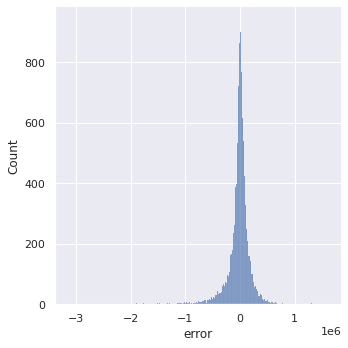

In [ ]:
train['error'] = train['Price_pred'] - train['Price']
train['error_abs'] = abs(train['error'])
sns.displot(train['error'])

In [ ]:
train['error_abs'].describe()

count    1.837300e+04
mean     1.319399e+05
std      2.042924e+05
min      5.750215e+00
25%      2.771880e+04
50%      6.891634e+04
75%      1.558057e+05
max      3.152493e+06
Name: error_abs, dtype: float64

### Величина максимальной ошибки крайне велика - 3152493.0. Посмотрим на топ-10 ошибок


In [ ]:
train.sort_values('error_abs',ascending=False).head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,second,year,month,day,years_purch_to_sale,YearBuilt_groups,BuildingArea_groups,Price_pred,error,error_abs
1502,Brighton,11 Kent Av,4,h,5250000.0,VB,hockingstuart,27/06/2016,11.2,3186.0,...,1466985600000000000,2016,6,27,57,"(1940, 1960]",NaN,2.097507e+06,-3.152493e+06,3.152493e+06
8171,Toorak,37 Tintern Av,3,h,5000000.0,VB,Kay,28/05/2016,4.6,3142.0,...,1464393600000000000,2016,5,28,76,"(1920, 1940]",NaN,1.931035e+06,-3.068965e+06,3.068965e+06
2205,Canterbury,14 Monomeath Av,5,h,5110000.0,S,Jellis,28/05/2016,9.0,3126.0,...,1464393600000000000,2016,5,28,61,"(1940, 1960]",NaN,2.294163e+06,-2.815837e+06,2.815837e+06
1321,Box Hill,6 Archibald St,3,h,4000000.0,VB,Lindellas,18/06/2016,13.1,3128.0,...,1466208000000000000,2016,6,18,71,"(1940, 1960]","(110.0, 130.0]",1.269474e+06,-2.730526e+06,2.730526e+06
4544,Kew,51 Rowland St,2,h,4800000.0,S,Jellis,3/09/2016,5.6,3101.0,...,1457481600000000000,2016,3,9,79,"(1920, 1940]",NaN,2.111359e+06,-2.688641e+06,2.688641e+06
4840,Malvern,17 Spring Rd,4,h,5075000.0,S,RT,25/02/2017,7.4,3144.0,...,1487980800000000000,2017,2,25,77,"(1920, 1940]",NaN,2.405216e+06,-2.669784e+06,2.669784e+06
13415,South Melbourne,47 Howe Cr,3,h,4600000.0,S,Marshall,27/05/2017,1.9,3205.0,...,1495843200000000000,2017,5,27,107,"(1900, 1920]",NaN,1.957935e+06,-2.642065e+06,2.642065e+06
327,Armadale,11/17 Myamyn St,2,u,3625000.0,S,Jellis,4/06/2016,6.3,3143.0,...,1459900800000000000,2016,4,6,10,"(2000, 2010]",NaN,1.001404e+06,-2.623596e+06,2.623596e+06
9766,Caulfield North,6/24 Park Cr,1,u,3050000.0,SP,Gary,6/05/2017,8.1,3161.0,...,1496620800000000000,2017,6,5,43,"(1960, 1980]",NaN,4.405487e+05,-2.609451e+06,2.609451e+06
12946,Brighton,24 Norwood Av,5,h,5300000.0,PI,Marshall,27/05/2017,10.5,3186.0,...,1495843200000000000,2017,5,27,64,"(1940, 1960]",NaN,2.736342e+06,-2.563658e+06,2.563658e+06


### Здесь мы видим схожие объекты по ряду признаков:
- преимущественно дома старые;
- тип объекта - h;
- предсказанная цена была сильно занижена относительно истинной


In [ ]:
train['price_group'] = pd.qcut(train['Price'], 5)

In [ ]:
cm = sns.dark_palette("red", as_cmap=True)

def print_error(col):
    t = train.groupby(col)[['error_abs','error']].agg(['count','mean'])
    t.columns = ['_'.join(col).strip() for col in t.columns.values]
    t = t.drop('error_count',axis=1)
    t['diff_abs_mean_error'] = t['error_abs_mean'] - train['error_abs'].mean()
    t['mean_error'] = train['error_abs'].mean()
    display(t.style.background_gradient(cmap=cm, subset=['diff_abs_mean_error']))

### Здесь столбцы означают следующее:
- error_abs_count - число наблюдений в группе
- error_abs_mean - средняя абсолютная ошибка по группе
- error_mean - средняя ошибка (для понимания направления ошибки)
- diff_abs_mean_error - разница между средней абсолютной ошибкой по группе и средней абсолютной ошибкой по всему train. Интерпретация: если данная величина отрицательная, то ошибка ниже средней абсолюной (модель работает хорошо на данной градации); если данная величина положительная, то ошибка выше асболютной (модель плохо работает на данной градации).

### Группы цен:


In [ ]:
print_error('price_group')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
price_group,,,,,
"(226999.999, 590000.0]",3702,53684.378187,34189.952790,-78255.552063,131939.930251
"(590000.0, 777000.0]",3650,64487.910906,10987.196123,-67452.019345,131939.930251
"(777000.0, 1005000.0]",3683,100272.802905,27647.582392,-31667.127346,131939.930251
"(1005000.0, 1416000.0]",3664,135560.543141,2717.635723,3620.612890,131939.930251
"(1416000.0, 5580000.0]",3674,305937.216243,-197674.391093,173997.285992,131939.930251


##### Модель прогнозирует тем лучше, чем ниже цена на объект, и совсем плохо прогнозирует наиболее дорогостоящие объекты (80 перцентиль и выше)

### Год постройки:

In [ ]:
print_error('YearBuilt_groups')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
YearBuilt_groups,,,,,
"(1850, 1900]",755,178317.607999,-29696.935970,46377.677749,131939.930251
"(1900, 1920]",1030,210230.376044,-39720.649119,78290.445793,131939.930251
"(1920, 1940]",1714,199632.737151,-30074.717017,67692.806900,131939.930251
"(1940, 1960]",3577,161647.546042,-26707.039012,29707.615792,131939.930251
"(1960, 1980]",5334,110395.822575,-25944.511970,-21544.107676,131939.930251
"(1980, 2000]",3330,97234.823612,-20389.123285,-34705.106638,131939.930251
"(2000, 2010]",1804,94055.005162,-10652.964075,-37884.925089,131939.930251
"(2010, 2020]",824,84192.863676,-14515.295898,-47747.066574,131939.930251


##### Модель плохо прогнозирует цены на объекты построенные ранее 1960-го года, и в целом хорошо позже 1960-го

### Расстояние до центрального района:

In [ ]:
train['Distance_group'] = pd.qcut(train['Distance'], 5)
print_error('Distance_group')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
Distance_group,,,,,
"(-0.001, 5.5]",3747,164546.040184,-43411.659269,32606.109934,131939.930251
"(5.5, 8.4]",3822,156900.118262,-28642.864692,24960.188011,131939.930251
"(8.4, 11.2]",4066,142503.450762,-26205.886507,10563.520512,131939.930251
"(11.2, 13.9]",3398,101898.524630,-8840.000376,-30041.405621,131939.930251
"(13.9, 48.1]",3340,84501.753424,-11697.546891,-47438.176827,131939.930251


##### Модель тем сильнее ошибается, чем ближе объект к центральному району, что очевидно связано и с годом постройки

### Тип объекта:

In [ ]:
print_error('Type')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
Type,,,,,
h,12091,155430.978041,-26494.413539,23491.047790,131939.930251
t,2007,97498.539220,-11001.262207,-34441.391031,131939.930251
u,4275,81669.430359,-24648.957008,-50270.499891,131939.930251


### Название региона:

In [ ]:
print_error('Rooms')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
Rooms,,,,,
1,886,60981.053173,-15625.812454,-70958.877078,131939.930251
2,4995,96182.934386,-20292.376878,-35756.995865,131939.930251
3,7958,124912.170150,-19808.642947,-7027.760101,131939.930251
4,3646,183610.832997,-29409.687509,51670.902746,131939.930251
5,768,252656.680602,-77685.696307,120716.750351,131939.930251
6,90,228114.651569,-28001.532975,96174.721319,131939.930251
7,13,303419.002402,-73057.887219,171479.072151,131939.930251
8,11,354990.512459,-87518.415277,223050.582209,131939.930251
9,1,112860.336536,-112860.336536,-19079.593715,131939.930251


##### Здесь мы не можем увидеть какой-либо явной закономерности. Но очевидно модель лучше отрабатывает на объектах с малым числом комнат, и хуже работает на объектах с большим числом комнат. Скорее всего это связано с малым числом наблюдений для недвижимости с 7+ комнатами.

### Округ:

In [ ]:
print_error('CouncilArea')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
CouncilArea,,,,,
Banyule City Council,947,101499.584542,-18995.496540,-30440.345708,131939.930251
Bayside City Council,857,217701.719793,-37397.435574,85761.789543,131939.930251
Boroondara City Council,1896,236564.226740,-50014.815833,104624.296489,131939.930251
Brimbank City Council,874,59447.463539,-11744.846678,-72492.466712,131939.930251
Cardinia Shire Council,13,58572.012198,11161.371042,-73367.918053,131939.930251
Casey City Council,74,48999.291468,-12211.472904,-82940.638783,131939.930251
Darebin City Council,1714,97134.436002,-10263.414407,-34805.494248,131939.930251
Frankston City Council,114,81815.626948,-28331.898490,-50124.303302,131939.930251
Glen Eira City Council,1251,121925.249636,-7997.879445,-10014.680615,131939.930251


### Район:

In [ ]:
print_error('Suburb')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
Suburb,,,,,
Abbotsford,82,141252.479528,42324.704638,9312.549277,131939.930251
Aberfeldie,53,215908.319682,-122933.058794,83968.389432,131939.930251
Airport West,107,59287.695733,-4221.283117,-72652.234518,131939.930251
Albanvale,8,37629.509101,30165.393538,-94310.421149,131939.930251
Albert Park,76,290303.188076,-129270.747111,158363.257825,131939.930251
Albion,42,52772.466659,-21172.372301,-79167.463591,131939.930251
Alphington,49,167665.989399,-55928.591189,35726.059148,131939.930251
Altona,90,79323.377916,-37586.064762,-52616.552335,131939.930251
Altona Meadows,9,45338.294520,-2224.876766,-86601.635730,131939.930251


##### Здесь также сложно выявить какую-то закономерность. Есть районы и округа, для которых ошибка меньше средней по всем данным, и наоборот

### Название региона:

In [ ]:
print_error('Regionname')

,error_abs_count,error_abs_mean,error_mean,diff_abs_mean_error,mean_error
Regionname,,,,,
Eastern Metropolitan,1999,123993.446940,-11083.983408,-7946.483311,131939.930251
Eastern Victoria,79,53428.969998,-17123.600828,-78510.960253,131939.930251
Northern Metropolitan,5305,99018.018157,-16978.593563,-32921.912094,131939.930251
Northern Victoria,63,44871.634895,-2838.679005,-87068.295356,131939.930251
South-Eastern Metropolitan,683,98316.685449,-31378.340679,-33623.244802,131939.930251
Southern Metropolitan,6326,194364.896123,-41289.118856,62424.965872,131939.930251
Western Metropolitan,3876,89228.742319,-13316.822352,-42711.187932,131939.930251
Western Victoria,42,32805.139240,4869.532580,-99134.791011,131939.930251


##### В целом, модель хорошо работает для всех регионов, кроме Southern Metropolitan

### Shap-value

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[X])

In [ ]:
shap_columns = [x + '_shap' for x in X]
shap_values_df = pd.DataFrame(shap_values, columns=shap_columns)
shap_values_df

,Suburb_shap,Street_shap,Rooms_shap,Type_shap,Method_shap,SellerG_shap,Distance_shap,Postcode_shap,Bedroom2_shap,Bathroom_shap,Car_shap,Landsize_shap,BuildingArea_shap,YearBuilt_shap,CouncilArea_shap,Lattitude_shap,Longtitude_shap,Regionname_shap,Propertycount_shap,second_shap
0,35394.732094,-3365.769870,10131.949536,56294.009046,19301.541908,-4639.781716,69612.017378,-16030.654991,-1120.912769,50535.465287,-17778.798494,-82029.652647,13787.762990,119856.180367,15051.243396,-5114.315379,-13245.440677,-36736.020777,-2909.243674,-71367.285774
1,-85298.420348,14278.939917,79112.734955,-60329.425186,13318.693147,-43805.853198,-76251.938326,-2207.447536,64217.325394,33345.259144,12995.137869,31658.878603,145116.355528,-29776.807234,-15130.179277,-95714.529432,7601.397719,-51893.711032,-823.645045,24882.247402
2,-20428.624788,-10747.310189,-154546.774276,-147964.424934,1213.735459,3021.218970,-11073.188124,-2316.478258,-103463.072716,-29403.135267,-15546.523779,-70299.398128,-17639.132071,-20625.209143,-61915.504657,16091.551338,-35602.726646,-48099.838603,-9829.453126,13423.970555
3,-53097.527057,-7349.655928,-157867.371720,-147458.614811,3071.165245,-22646.664410,29430.595965,-1115.299573,-118760.742599,-34935.930937,-20610.616410,-62989.291038,-23076.027519,-31943.333150,-47242.617972,10948.126857,20030.092296,2241.882756,-5055.181219,14601.819393
4,45978.601621,14493.319037,95276.587899,178866.024279,16489.502526,23410.232304,27553.245262,7630.325624,101789.154012,103971.922354,40334.459652,120068.713640,-4729.798199,-87144.329050,158797.735585,27418.248752,-47536.752071,134149.598748,-8752.371787,-53140.742536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18368,-60186.691848,-9093.159064,-57699.790177,-164999.634879,8877.016953,-18912.663886,41357.283338,-3142.082318,-65061.488047,-22523.504406,-8947.988336,-22087.158003,-9949.668571,-23040.172552,-68474.376159,2115.373444,-17902.461220,-52469.503368,-2848.457177,23761.237734
18369,29812.143357,-20677.310383,-90929.815367,62681.181017,-9431.596569,12373.920842,-80616.039114,5385.142863,-88395.489040,-21872.878159,-1376.642669,-34459.012354,-11114.448447,-48563.397368,19343.752727,14271.968550,-15015.463984,-12493.337535,-3642.589523,28153.282734
18370,46158.781529,7756.333019,17343.762998,-98770.139610,11068.068435,-20168.203725,-72650.157068,422.519603,15867.250058,-18169.108255,77.075314,8720.322298,-5805.991471,-21627.337454,24921.661557,16928.714171,-22622.264355,21429.989747,23780.396373,29080.293424
18371,-56875.086561,-10671.286853,-51215.736049,-78092.249197,-11679.609583,-32059.433747,-30534.292474,-2218.460569,-55050.462083,-17588.937140,-6409.555022,-18964.977474,-11351.558338,-21184.447701,-44533.952384,-19765.663437,10200.630345,-47833.622488,-1056.938978,30153.220194


In [ ]:
train_with_shap = pd.concat([train.reset_index(), shap_values_df],axis=1)

In [ ]:
train_with_shap = train_with_shap.sort_values('error_abs',ascending=False)

### Комнаты:

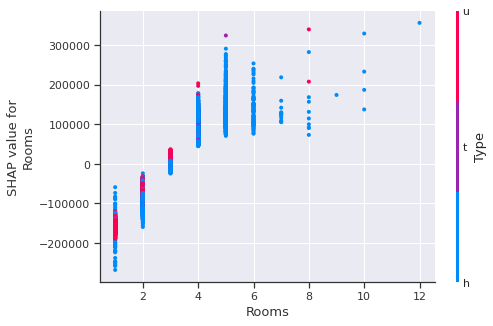

In [ ]:
shap.dependence_plot("Rooms", shap_values, train[X])

##### С увеличением числа комнат модель добавляет к цене

### Год постройки:

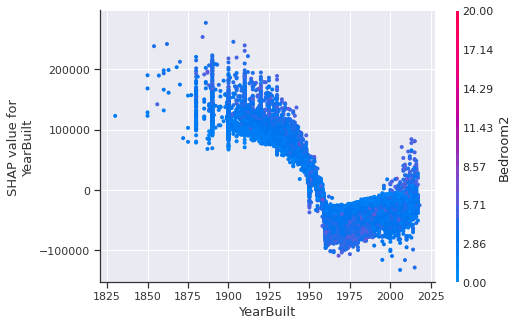

In [ ]:
shap.dependence_plot("YearBuilt", shap_values, train[X])

##### С увеличением года постройки модель добавляет меньше к цене

### Расстояние до центрального района:

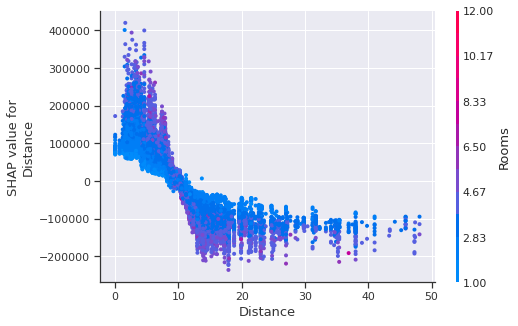

In [ ]:
shap.dependence_plot("Distance", shap_values, train[X])

##### С увеличением дистанции до центрального района модель добавляет к цене меньше

### Регион:

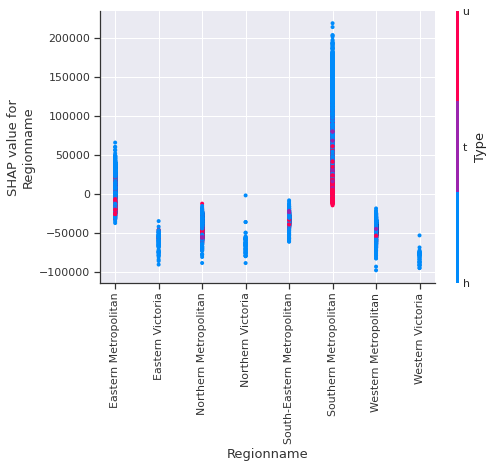

In [ ]:
shap.dependence_plot("Regionname", shap_values, train[X])

### Район:

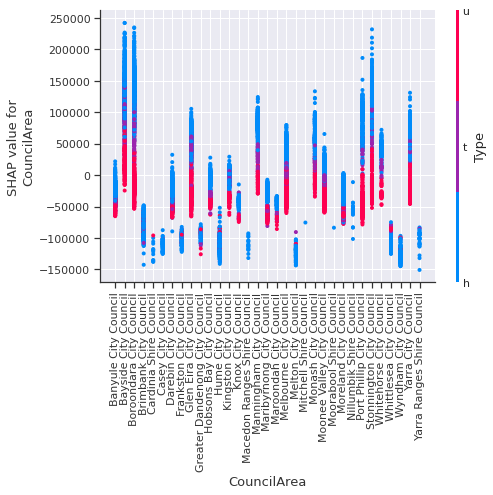

In [ ]:
shap.dependence_plot("CouncilArea", shap_values, train[X])

### Тип:

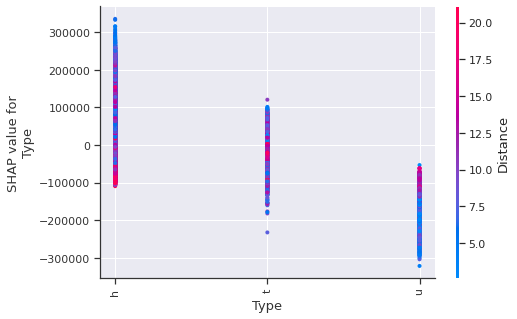

In [ ]:
shap.dependence_plot("Type", shap_values, train[X])

### Дата продажи:

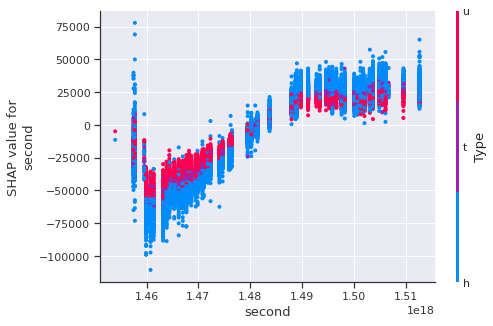

In [ ]:
shap.dependence_plot("second", shap_values, train[X])

##### Чем позже был продан объект, тем больше добавляет модель

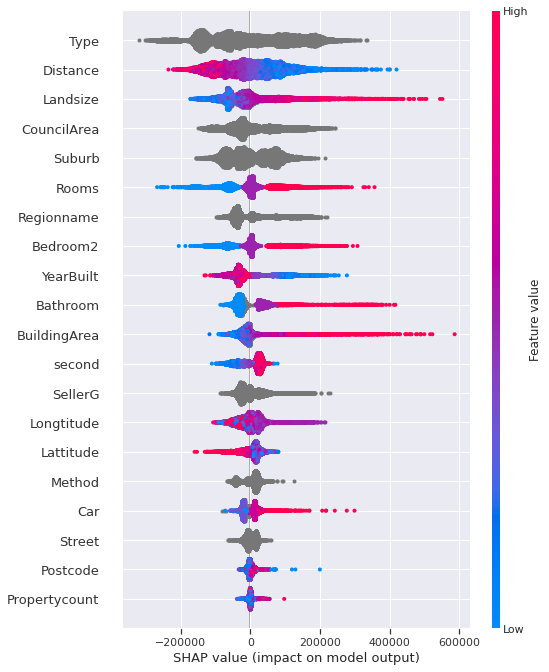

In [ ]:
shap.summary_plot(shap_values, train[X])